# Ansatz Verification

In this notebook, we numerically verify the ansatz we made to solve the 1D moisture equation forced by stochastic noise. We first do a toy example, then simulate the full dynamics.

In [1]:
# Import general functions
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl 
from random import randrange 
from scipy.special import lambertw

mpl.rcParams['mathtext.fontset'] = 'stix'
mpl.rcParams['font.family'] = 'STIXGeneral'

cms = mpl.cm 

import sys
sys.path.append("/data/keeling/a/adammb4/heatwaves-physics/src/")
from getSimluationFluxes import * 
from getAnalyticVerificationFuncs import *
from getSimulate import * 

In [2]:
# setup 
# define model parameters 
C = 4180 # J/K
F = 300 # W / m^2
alpha = 10 # W / K for now, usually between 5 and 25
v_L = 1.25 * 10**(-2) # kg air / m^2 / s
L = 2.5 * 10**6 # J / kg H20
gamma = 3.7 * 10**(-4) # kg H20 / kg air / K
m0 = 0.1
T_D = 290 # K 
mu = 50 # kg / m^2

param_list = [C, F, alpha, v_L, L, gamma, T_D, mu, m0]

Here we test the validity of our ansatz that the 1D moisture equation is solved by a superposition of Lambert W functions. To do this, we need to create our precipitation forcing, which we do first.

Precip can be modeled as instantaneous injections of moisture into the soil column, with amplitudes drawn from a Gamma distribution and frequencies drawn from a Poisson distribution. 

### Toy Model: Manually Input Fluxes

In [12]:
N_steps_toy = 10**6
timestep = 1
time = np.arange(0, N_steps_toy * timestep, timestep)

# setup precip fluxes 
moisture = np.zeros(N_steps_toy)
moisture_full = np.zeros_like(moisture)
temp = np.zeros_like(moisture)
temp[0] = 310
moisture_full[0] = 0.2
precip = np.zeros(N_steps_toy)

p_event1 = 0.5
p_event2 = 0.2
p_event3 = 0.4

t_event1 = 0
t_event2 = int(N_steps_toy/10)
t_event3 = int(N_steps_toy * 2/3)
precip[0] = p_event1
precip[t_event2] = p_event2
precip[t_event3] = p_event3

In [13]:
# simulate moisutre evo with 1D equation
for i in range(1, N_steps_toy):
    temp[i] = temp[i-1] + timestep * getTFluxFull(temp[i-1], moisture_full[i-1], param_list)
    moisture_full[i] = moisture_full[i-1] + timestep * getMFluxFull(temp[i-1], moisture_full[i-1], param_list, precip[i-1])
    moisture[i] = moisture[i - 1] + timestep * getMFlux1D(moisture[i-1], param_list, precip[i - 1])

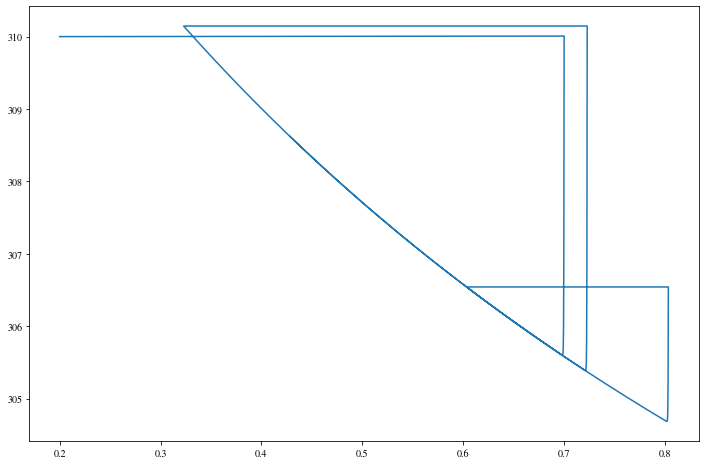

In [14]:
fig, ax = plt.subplots(1, figsize=(12,8))

ax.plot(moisture_full, temp)

In [ ]:
# make my ansatz
heaviside1 = getHeaviside(N_steps_toy, t_event1 * timestep + timestep)
heaviside2 = getHeaviside(N_steps_toy, t_event2 * timestep + timestep)
heaviside3 = getHeaviside(N_steps_toy, t_event3 * timestep + timestep)

kappa = L * v_L * gamma * alpha**(-1)
timescale = mu * alpha * ( F * v_L * gamma)**(-1)

exp1 = np.exp(- (time - (t_event1 * timestep + timestep)) / timescale)
exp2 = np.exp(- (time - (t_event2 * timestep + timestep)) / timescale)
exp3 = np.exp(- (time - (t_event3 * timestep + timestep)) / timescale)

arg1 = kappa * p_event1 * np.exp(kappa * p_event1) * exp1
arg2 = kappa * p_event2 * np.exp(kappa * p_event2) * exp2
arg3 = kappa * p_event3 * np.exp(kappa * p_event3) * exp3

ansatz = heaviside1 * kappa**(-1) * lambertw(arg1, k=0, tol=1e-8) + heaviside2 * kappa**(-1) * lambertw(arg2,k=0,tol=1e-8) + heaviside3 * kappa**(-1) * lambertw(arg3,k=0,tol=1e-8)

In [ ]:
# make Lucas ansatz
Lansatz = heaviside1 * p_event1 * exp1 + heaviside2 * p_event2 * exp2 + heaviside3 * p_event3 * exp3

In [ ]:
fig, ax = plt.subplots(2, figsize=(12,8), sharex=True)

ax[0].plot(time, moisture, color='r', label="Full numerics")
ax[0].plot(time, ansatz, color='b', linestyle='dotted', label=r"$m(t,p) = \dfrac{1}{\kappa} \sum_{j} W_{0}\left( \kappa p_{j} e^{\kappa p_{j}} e^{-(t - t_{j})/\tau_{2}} \right)$")
ax[0].plot(time, Lansatz, color='g', linestyle='-.', label=r"$m(t,p) = \sum_{j} p_{j} e^{-(t - t_{j})/\tau_{2}}$")
ax[0].legend(bbox_to_anchor=(1,1), loc='upper left',frameon=False, fontsize=18)
ax[0].set_ylabel("Moisture fraction", fontsize = 22)

ax[1].plot(time, abs(moisture - ansatz), color='b', linestyle='dotted')
ax[1].plot(time, abs(moisture - Lansatz), color='g', linestyle='-.')
ax[1].set_ylabel(r"$\left(m_{full} - m_{ana}\right)/m_{full}$", fontsize = 22)
ax[1].set_xlabel("Time (s)", fontsize = 22)

fig.savefig("./figures/9_27_2021_verify_ansatz_toymodel.png", dpi=400)
fig.savefig("../docs/figdump/9_27_2021_verify_ansatz_toymodel.png", dpi=400)

### Full Model: Physical Precipitation Model and Month-long simulation

#### Preliminaries

From Google, in Illinois it rains ~108 days per year. So for 365 days per year, let's say the average time between rain events is ~3.5. This sets $\omega = 3.5$, where $\omega$ is the mean of the Poisson distribution.

This will set the *interval* between rain events. There will be one occuring at $t=0$. Also, $\omega$ represents the amount of time *in days* between rain events, but our simulation timestep will be less than one day. So this will have to be transformed using dimensional analysis, which will happen later on.

I will take the average precip event to have amplitude of 0.05, such that $p_{0} = 0.05$; this implies that the average rain event fills 5% of the soil column's moisture fraction. The scale parameter is set to 1.

In [ ]:
dist_size = 10**6
precip_mean = 0.2
precip_scale = 0.5 # no basis for why this is set to one...
precip_amplitudes = np.random.gamma(precip_mean, precip_scale, size=dist_size)

poisson_mean = 3.5 # omega
precip_freqs = np.random.poisson(3.5, size=dist_size)

plt.hist(precip_amplitudes, bins=50)
np.mean(precip_amplitudes)

In [ ]:
N_steps = 7776000 # approx one summer's worth of seconds
timestep = 1
time = np.arange(0, N_steps * timestep, timestep)
# 86400 seconds in one day 
omega_timestep = 3.5 * 86400 * timestep**(-1)

In [ ]:
moisture_full = np.zeros(N_steps)
ansatz_full = np.zeros(N_steps)
ansatz_full_exp = np.zeros(N_steps)

moisture_2d = np.zeros(N_steps)
temperature = np.zeros(N_steps)

tracker = 1

kappa = L * v_L * gamma * alpha**(-1)
timescale = mu * alpha * ( F * v_L * gamma)**(-1)

for i in range(1, N_steps):
    if i == tracker:
        tmp_precip = np.random.gamma(precip_mean, precip_scale)
        moisture_full[i] = moisture_full[i-1] + timestep * getMFlux1D(moisture_full[i-1], param_list, tmp_precip)
        
        moisture_2d[i] = moisture_2d[i-1] + timestep * getMFluxFull(temperature[i-1], moisture_2d[i-1], param_list, tmp_precip)
        temperature[i] = temperature[i-1] + timestep * getTFluxFull(temperature[i-1], moisture_2d[i-1], param_list)
        
        tmp_heaviside = getHeaviside(N_steps, i * timestep)
        tmp_exp = np.exp(- (time - (i * timestep)) / timescale)
        tmp_arg = kappa * tmp_precip * np.exp(kappa * tmp_precip) * tmp_exp
        tmp_ansatz = tmp_heaviside * kappa**(-1) * lambertw(tmp_arg, k=0, tol=1e-8)
        tmp_ansatz_exp = tmp_precip * tmp_exp * tmp_heaviside
        
        ansatz_full = ansatz_full + tmp_ansatz
        ansatz_full_exp = ansatz_full_exp + tmp_ansatz_exp
        tracker += int(np.random.poisson(omega_timestep))
    else:
        moisture_full[i] = moisture_full[i-1] + timestep * getMFlux1D(moisture_full[i-1], param_list, 0)
        moisture_2d[i] = moisture_2d[i-1] + timestep * getMFluxFull(temperature[i-1], moisture_2d[i-1], param_list, 0)
        temperature[i] = temperature[i-1] + timestep * getTFluxFull(temperature[i-1], moisture_2d[i-1], param_list)

In [ ]:
fig, ax = plt.subplots(2, sharex=True, figsize=(14,10))

ax[0].plot(time, moisture_2d, color='k', linestyle="-", label="Full dynamics", linewidth=2.5, zorder=1)
ax[0].plot(time, moisture_full, color='#E69F00', linestyle='dotted', label="Hasselmann", linewidth=1.75, zorder=3)
ax[0].plot(time, ansatz_full, color='#56B4E9', linestyle='dashed', alpha=0.8, label='Lambert $W$',linewidth=1, zorder=5)
ax[0].plot(time, ansatz_full_exp, color='#009E73', linestyle="dashdot", label="Exponential", linewidth=1, zorder=7)
ax[0].set_ylabel("Moisture Fraction", fontsize=22)
ax[0].legend(frameon=False, fontsize=20)
ax[0].tick_params(axis="both", labelsize=20)

ax[1].plot(time, abs(moisture_full - ansatz_full), color='#56B4E9', linestyle='dashed')
ax[1].plot(time, abs(moisture_full - ansatz_full_exp), color='#009E73', linestyle='dashdot')
ax[1].set_ylabel("Rel. Diff", fontsize=22)
ax[1].tick_params(axis="both", labelsize=20)
ax[1].set_xlabel(r"Time (days)", fontsize=22)

ax[1].set_xticklabels([0,15,30,45,60,75,90])
ax[1].set_xticks([0 * 86400, int(15 *86400), int(30 *86400), int(45 *86400), int(60 *86400), int(75 *86400), int(90 *86400)])

ax[1].set_xlim([0, int(90 * 86400)])

fig.savefig("./figures/1_7_2021_verify_ansatz_fullsummer_exp.png", dpi=400)
fig.savefig("../docs/figdump/1_7_2021_verify_ansatz_fullsummer_exp.png", dpi=400)